# A notebook to visualise the tracks

In [1]:
import anaconfig


In [49]:
import typing
import os
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from matplotlib.axes import Axes

from dfutils import get_df_edges

from Preprocessing.preprocessing import load_dataframes
from utils.plotutils.plotconfig import configure_matplotlib
from utils.plotutils.plotools import save_fig
configure_matplotlib()


In [3]:
input_dir = "/scratch/acorreia/data/focal-loss-nopid-triplets-embedding-3/metric_learning_processed/test/"
test_dataset_name = "minbias-sim10b-xdigi-nospillover_v2.1_98"

input_paths = [
    file_.path
    for file_ in os.scandir(op.join(input_dir, test_dataset_name))
    if file_.is_file()
]


In [4]:
batch = torch.load(input_paths[10], map_location="cpu")

In [5]:
df_hits = pd.DataFrame(
    {
        "hit_idx": np.arange(batch["x"].shape[0]),
        "plane": batch["plane"].numpy(),
        **{axis: batch[f"un_{axis}"] for axis in ["x", "y", "z"]},
    }
)

df_hits_particles = pd.DataFrame(
    {
        "particle_id": batch["particle_id_hit_idx"][:, 0].numpy(),
        "hit_idx": batch["particle_id_hit_idx"][:, 1].numpy(),
    }
)

df_edges = get_df_edges(edge_indices=batch["edge_index"].numpy(), df_hits=df_hits)
df_true_edges = get_df_edges(
    edge_indices=batch["signal_true_edges"].numpy(), df_hits=df_hits
)


In [58]:
min_plane = 10
plane_range = 2
n_hits = 1

df_hits_plane_range = df_hits[
    (df_hits["plane"] >= min_plane) & (df_hits["plane"] <= min_plane + plane_range)
].reset_index(drop=True)


def filter_edges_planes(
    df_edges: pd.DataFrame, min_plane: int, plane_range: int
) -> pd.DataFrame:
    return df_edges[
        (df_edges["plane_left"] >= min_plane)
        & (df_edges["plane_right"] <= min_plane + plane_range)
    ].reset_index(drop=True)


df_edges_plane_range = filter_edges_planes(
    df_edges=df_edges, min_plane=min_plane, plane_range=plane_range
)
df_true_edges_plane_range = filter_edges_planes(
    df_edges=df_true_edges, min_plane=min_plane, plane_range=plane_range
)

In [43]:
rng = np.random.default_rng(seed=1)

In [44]:
first_plane_hit_indices = df_hits_plane_range[
    df_hits_plane_range["plane"] == min_plane
]["hit_idx"].to_numpy()
chosen_first_plane_hit_indices = rng.choice(first_plane_hit_indices, size=n_hits)


In [59]:
def plot_hits(
    ax: Axes, df_hits: pd.DataFrame, axes: typing.Tuple[str, str] = ("z", "x")
):
    ax.set_xlabel(axes[0])
    ax.set_ylabel(axes[1])
    ax.scatter(x=df_hits[axes[0]], y=df_hits[axes[1]], s=1, c="k")


def plot_edges(
    ax: Axes,
    df_edges: pd.DataFrame,
    axes: typing.Tuple[str, str] = ("z", "x"),
    **kwargs,
):
    for _, edge in df_edges.iterrows():
        ax.plot(
            (edge[f"{axes[0]}_left"], edge[f"{axes[0]}_right"]),
            (edge[f"{axes[1]}_left"], edge[f"{axes[1]}_right"]),
            **kwargs,
        )

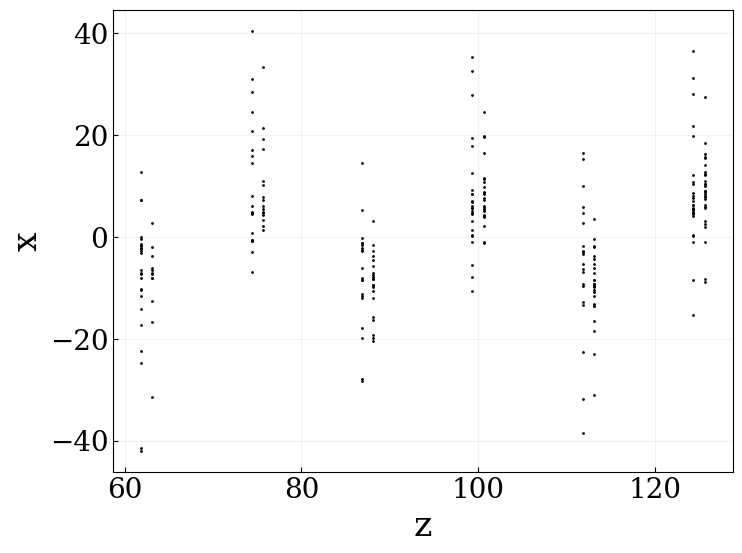

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_hits(ax=ax, df_hits=df_hits_plane_range)
ax.grid(color="grey", alpha=0.1)


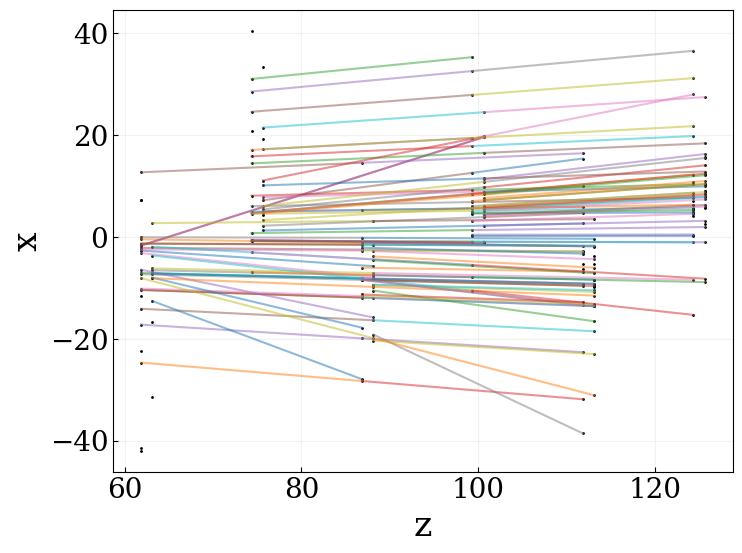

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_edges(ax=ax, df_edges=df_true_edges_plane_range, alpha=0.5)
plot_hits(ax=ax, df_hits=df_hits_plane_range)

ax.grid(color="grey", alpha=0.1)

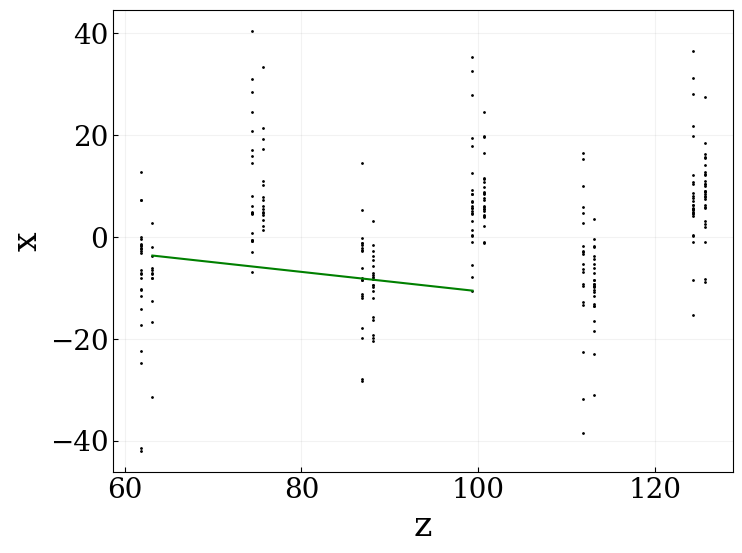

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_edges(
    ax=ax,
    df_edges=df_true_edges_plane_range[
        df_true_edges_plane_range["hit_idx_left"].isin(chosen_first_plane_hit_indices)
    ],
    color="g",
)
plot_hits(ax=ax, df_hits=df_hits_plane_range)

ax.grid(color="grey", alpha=0.1)

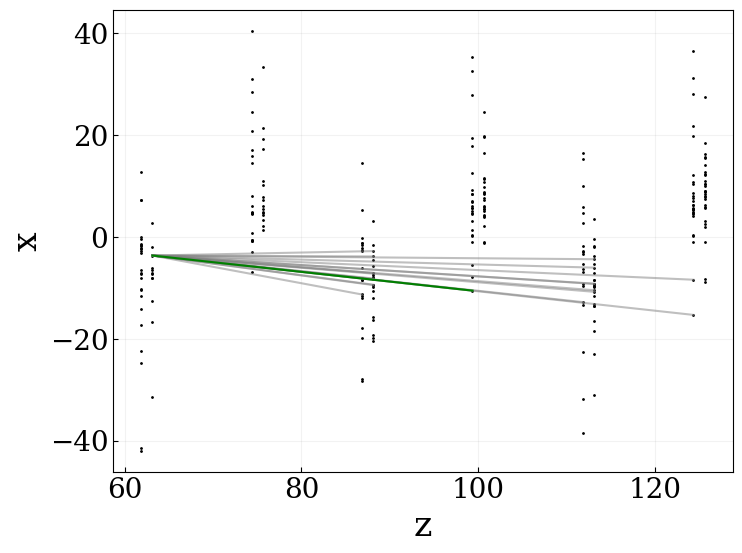

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_edges(
    ax=ax,
    df_edges=df_edges_plane_range[
        df_edges_plane_range["hit_idx_left"].isin(chosen_first_plane_hit_indices)
    ],
    color="grey",
    alpha=0.5,
)

plot_edges(
    ax=ax,
    df_edges=df_true_edges_plane_range[
        df_true_edges_plane_range["hit_idx_left"].isin(chosen_first_plane_hit_indices)
    ],
    color="g",
)
plot_hits(ax=ax, df_hits=df_hits_plane_range)

ax.grid(color="grey", alpha=0.1)

(array([ 30., 101., 203., 257., 296., 382., 288., 252., 188., 133., 124.,
         62.,  22.,  14.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([-0.5,  1.5,  3.5,  5.5,  7.5,  9.5, 11.5, 13.5, 15.5, 17.5, 19.5,
        21.5, 23.5, 25.5, 27.5, 29.5, 31.5, 33.5, 35.5, 37.5, 39.5, 41.5,
        43.5, 45.5, 47.5]),
 <BarContainer object of 24 artists>)

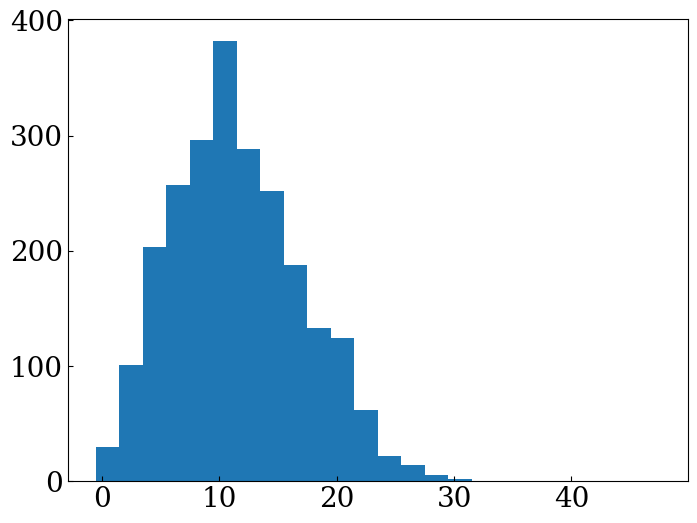

In [67]:
plt.hist(df_edges.groupby("hit_idx_left")["hit_idx_right"].count(), np.arange(0, 50, 2) - 0.5)